In [1]:
import os
import re
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

from typing import Literal

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))


# def show_pal0(palette):
#     sns.palplot(sns.color_palette(palette, 24))
#     print(palette)
# interact(show_pal0, palette='deep muted pastel bright dark colorblind'.split());

デフォルトのフォント: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']


## Table2: Cross Validation

In [2]:
mm = [
    'Accuracy', 
    'Accuracy(Patch)', 
    'F1 score', 
    'Precision', 
    'Recall', 
]

def dump_to_table(target:Literal['cv', 'ebrains'], result_limit=100):
    P = f'out/figs/table2_{target}.xlsx'
    r = None
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    vv = vvv[m].values
                    s = '{:.3f} ± {:.3f}'.format(np.mean(vv), stats.sem(vv))
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 
    
dump_to_table('cv', 500)

wrote out/figs/table2_cv.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
UNI(FT),0.942 ± 0.012,0.912 ± 0.005,0.861 ± 0.031,0.887 ± 0.037,0.866 ± 0.026
UNI(LP),0.949 ± 0.015,0.904 ± 0.009,0.885 ± 0.034,0.917 ± 0.030,0.883 ± 0.033
Prov-GigaPath(LP),0.949 ± 0.014,0.908 ± 0.008,0.881 ± 0.035,0.912 ± 0.030,0.881 ± 0.036
CTransPath(FT),0.947 ± 0.015,0.892 ± 0.007,0.876 ± 0.034,0.909 ± 0.030,0.879 ± 0.033
CTransPath(LP),0.939 ± 0.006,0.865 ± 0.008,0.866 ± 0.018,0.887 ± 0.015,0.870 ± 0.023
VIT-L$\mathrm{_{IN}}$(FT),0.927 ± 0.010,0.876 ± 0.009,0.833 ± 0.031,0.864 ± 0.035,0.833 ± 0.030
VIT-L$\mathrm{_{IN}}$(LP),0.907 ± 0.009,0.815 ± 0.007,0.826 ± 0.020,0.852 ± 0.023,0.829 ± 0.016
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.937 ± 0.013,0.880 ± 0.006,0.845 ± 0.039,0.858 ± 0.042,0.853 ± 0.037
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.369 ± 0.043,0.326 ± 0.026,0.233 ± 0.023,0.238 ± 0.007,0.355 ± 0.025


In [3]:
dump_to_table('ebrains', 500)

wrote out/figs/table2_ebrains.xlsx


,Accuracy,Accuracy(Patch),F1 score,Precision,Recall
UNI(FT),0.697 ± 0.013,0.697 ± 0.013,0.598 ± 0.012,0.616 ± 0.012,0.625 ± 0.009
UNI(LP),0.754 ± 0.006,0.754 ± 0.006,0.647 ± 0.005,0.648 ± 0.006,0.658 ± 0.005
Prov-GigaPath(LP),0.725 ± 0.008,0.725 ± 0.008,0.620 ± 0.008,0.632 ± 0.006,0.630 ± 0.006
CTransPath(FT),0.675 ± 0.010,0.675 ± 0.010,0.584 ± 0.007,0.593 ± 0.007,0.600 ± 0.006
CTransPath(LP),0.688 ± 0.011,0.688 ± 0.011,0.596 ± 0.007,0.614 ± 0.008,0.601 ± 0.007
VIT-L$\mathrm{_{IN}}$(FT),0.603 ± 0.015,0.603 ± 0.015,0.519 ± 0.013,0.547 ± 0.016,0.550 ± 0.010
ResNet-RS 50$\mathrm{_{IN}}$(FT),0.608 ± 0.014,0.608 ± 0.014,0.514 ± 0.014,0.549 ± 0.005,0.548 ± 0.011
VIT-L$\mathrm{_{IN}}$(LP),0.583 ± 0.016,0.583 ± 0.016,0.507 ± 0.014,0.530 ± 0.016,0.535 ± 0.010
ResNet-RS 50$\mathrm{_{IN}}$(LP),0.160 ± 0.020,0.160 ± 0.020,0.089 ± 0.006,0.154 ± 0.035,0.128 ± 0.015


## fig3: Box - Cross Validation

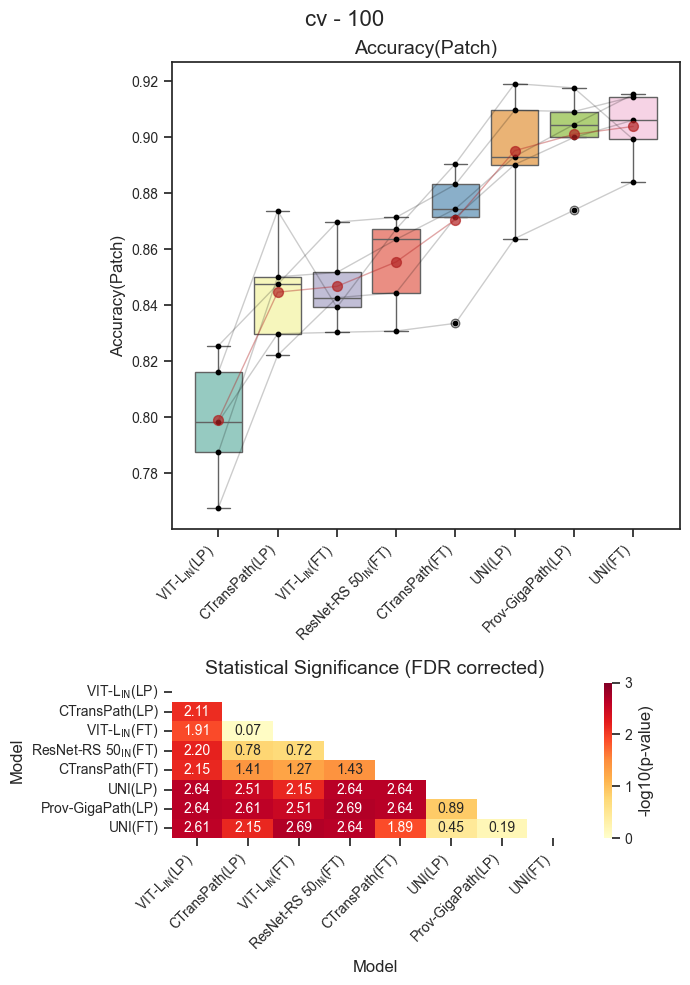

In [4]:
from statsmodels.stats.multitest import multipletests

def paired_box(target:Literal['cv', 'ebrains'], limit:int, key:str, title=None, verbose=False, excludes=['frozen_baseline-cnn']):
    df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    labels = df['label'].unique()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10), gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(hspace=0.3)
    
    # ボックスプロットの作成
    sns.boxplot(x='label', hue='label', y=key, data=df, palette='Set3', legend=False, ax=ax1)

    
    # foldごとにつないでプロット
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key], 'k-', alpha=0.2, linewidth=1)

    for i, label in enumerate(labels):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key], color='black', s=10, zorder=3)

    # 平均をプロット
    ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)
    ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    ax1.set_title(key)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key)

    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels[i]][key]
            b = df[df['label']==labels[j]][key]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)
    
    # Benjamini-Hochberg法による多重検定の補正
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    # p_corrected = p_values
       
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_corrected[k])  # 左下三角形に値を設定
            k += 1

        
    # マスクの作成（下三角形のみを表示）
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)
    
    # ヒートマップの作成
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd', 
                ax=ax2, cbar_kws={'label': '-log10(p-value)'}, vmin=0.0, vmax=3.0)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels, rotation=0)
    ax2.set_title('Statistical Significance (FDR corrected)')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')
    
    cbar_pos = heatmap.collections[0].colorbar.ax.get_position()
    ax1_pos = ax1.get_position()
    ax2_pos = ax2.get_position()
    new_width = cbar_pos.x0 - ax2_pos.x0
    ax1.set_position([ax1_pos.x0, ax1_pos.y0, new_width, ax1_pos.height])
    ax2.set_position([ax2_pos.x0, ax2_pos.y0, new_width, ax2_pos.height])
    plt.suptitle(f'{target} - {limit}', fontsize=16)
    plt.tight_layout()
paired_box('cv', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=300)
plt.show()

### CV 100 patches/case

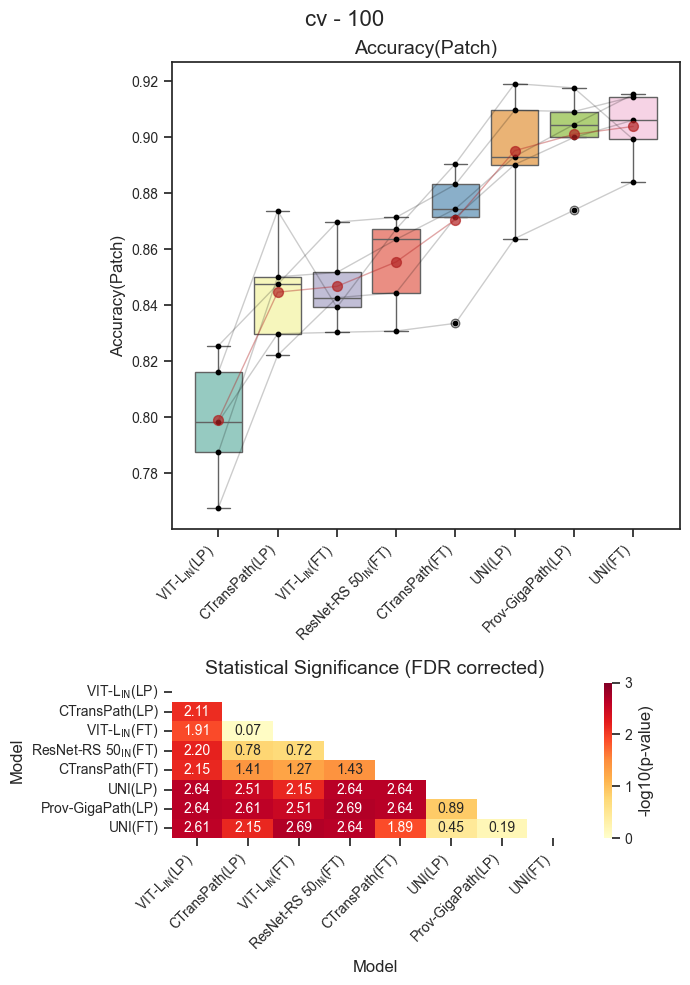

In [5]:
paired_box('cv', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=300)
plt.show()

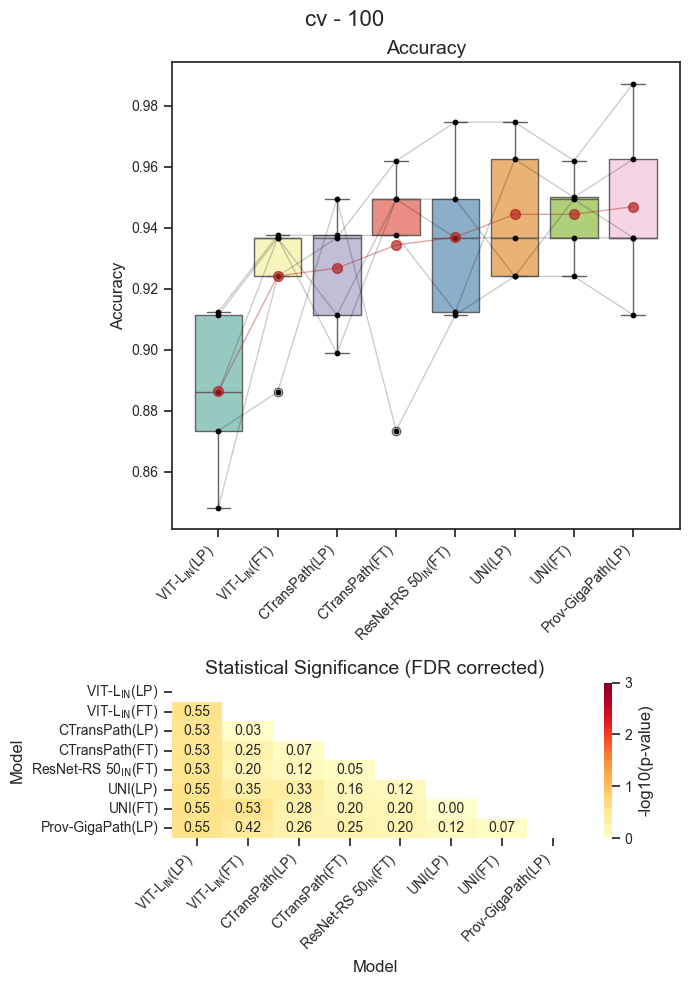

In [6]:
paired_box('cv', 100, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_cv_100_acc.png", format="png", dpi=300)
plt.show()

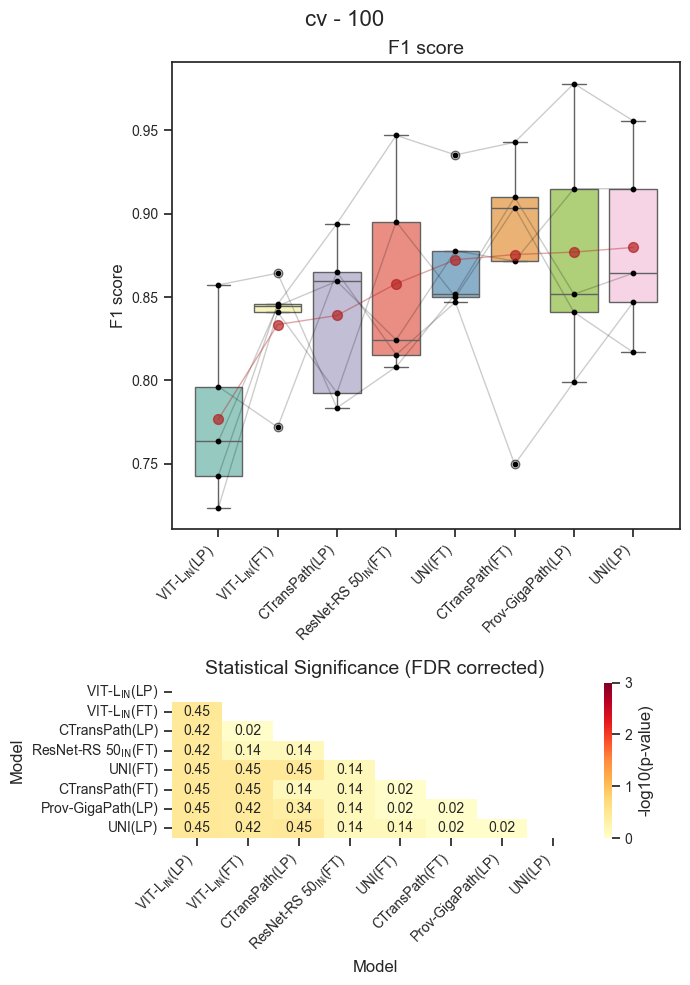

In [7]:
paired_box('cv', 100, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_cv_100_f1.png", format="png", dpi=300)
plt.show()

### EBRAINS 500 patches/case

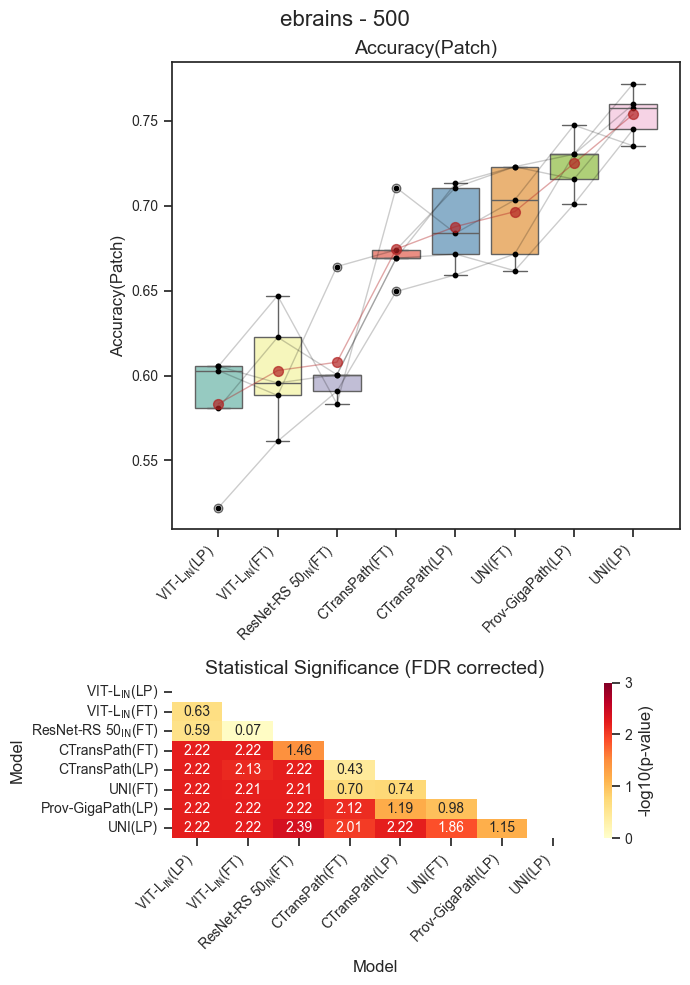

In [8]:
paired_box('ebrains', 500, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_500_pacc.png", format="png", dpi=300)
plt.show()

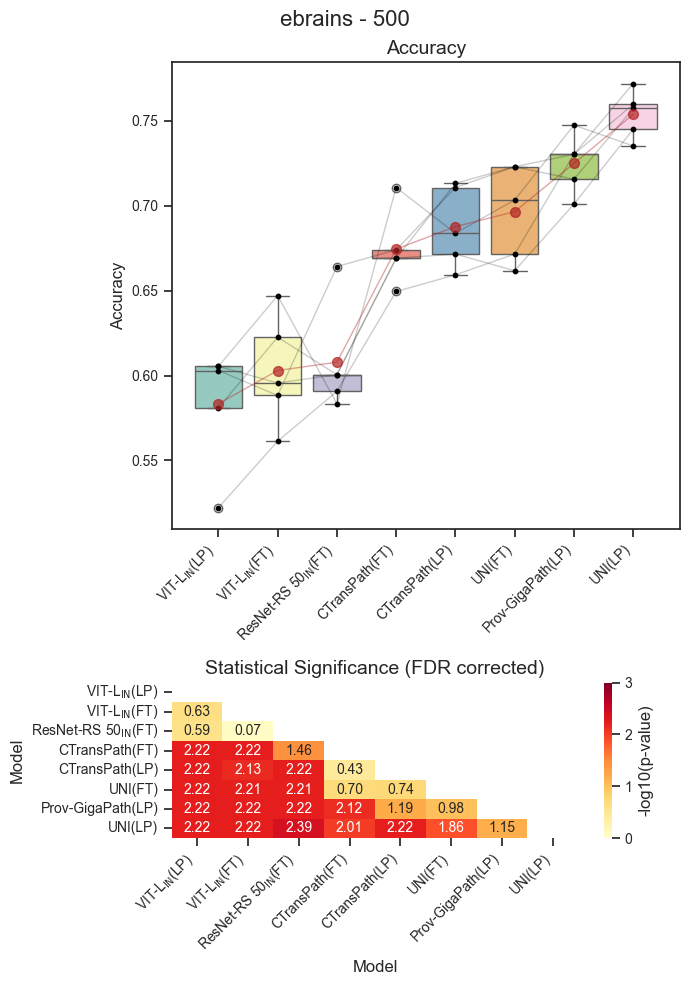

In [9]:
paired_box('ebrains', 500, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_500_acc.png", format="png", dpi=300)
plt.show()

### EBRAINS 100 patches/case

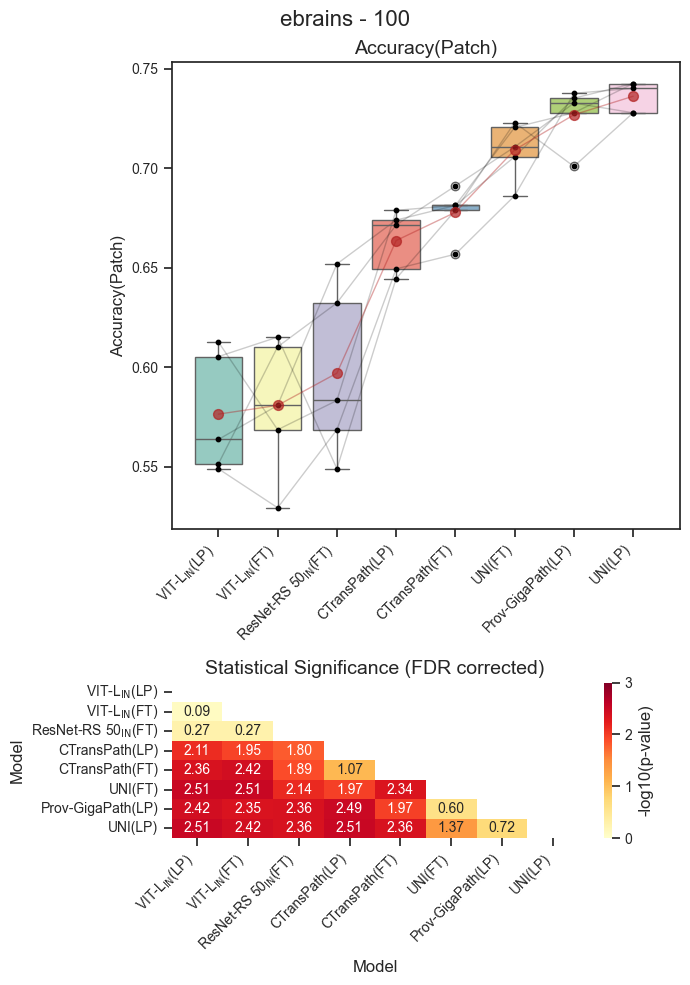

In [10]:
paired_box('ebrains', 100, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_100_pacc.png", format="png", dpi=300)
plt.show()

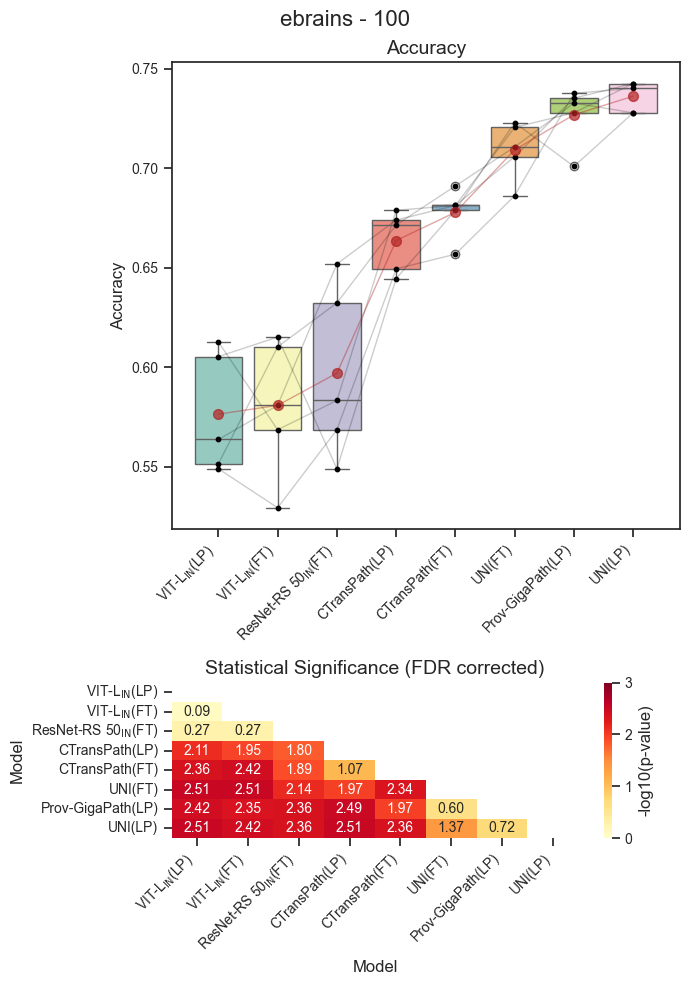

In [11]:
paired_box('ebrains', 100, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_acc.png", format="png", dpi=300)
plt.show()

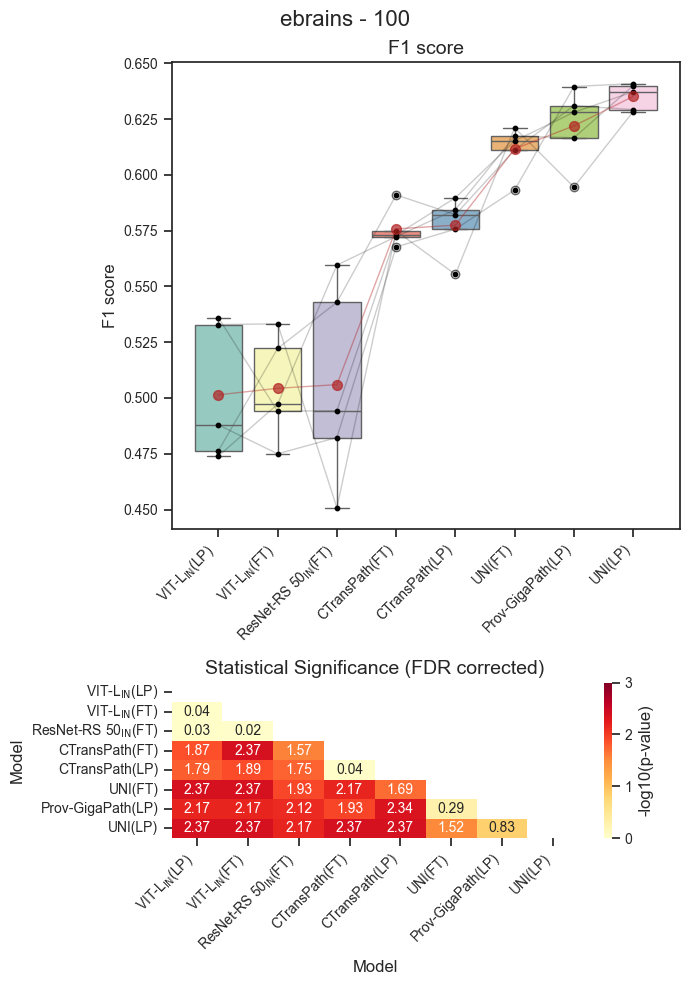

In [12]:
paired_box('ebrains', 100, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=300)
plt.show()

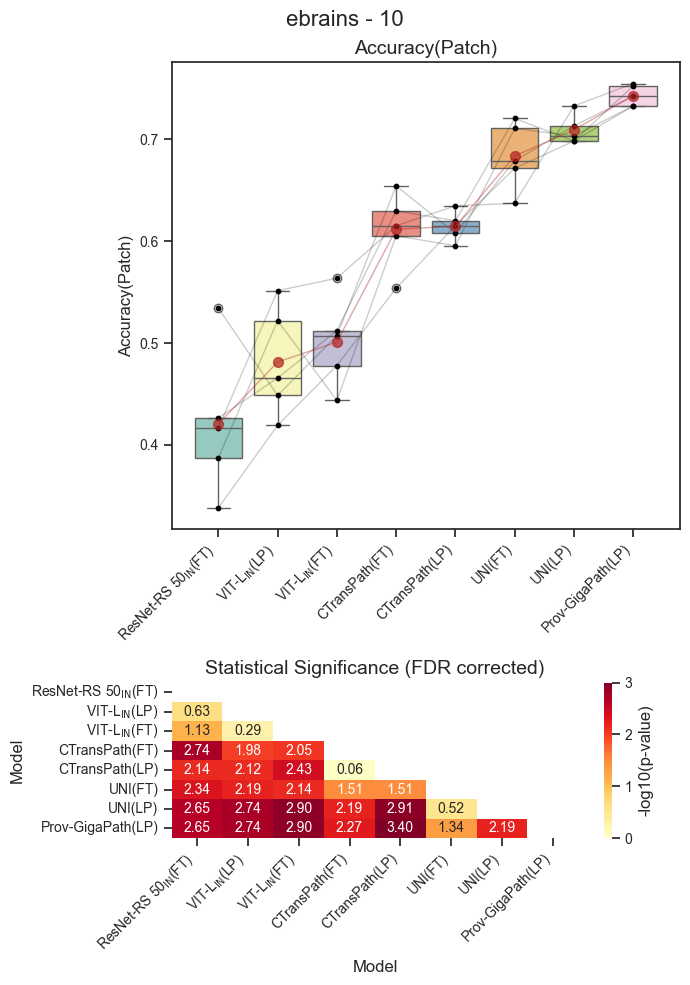

In [13]:
paired_box('ebrains', 10, 'Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_pacc.png", format="png", dpi=300)
plt.show()

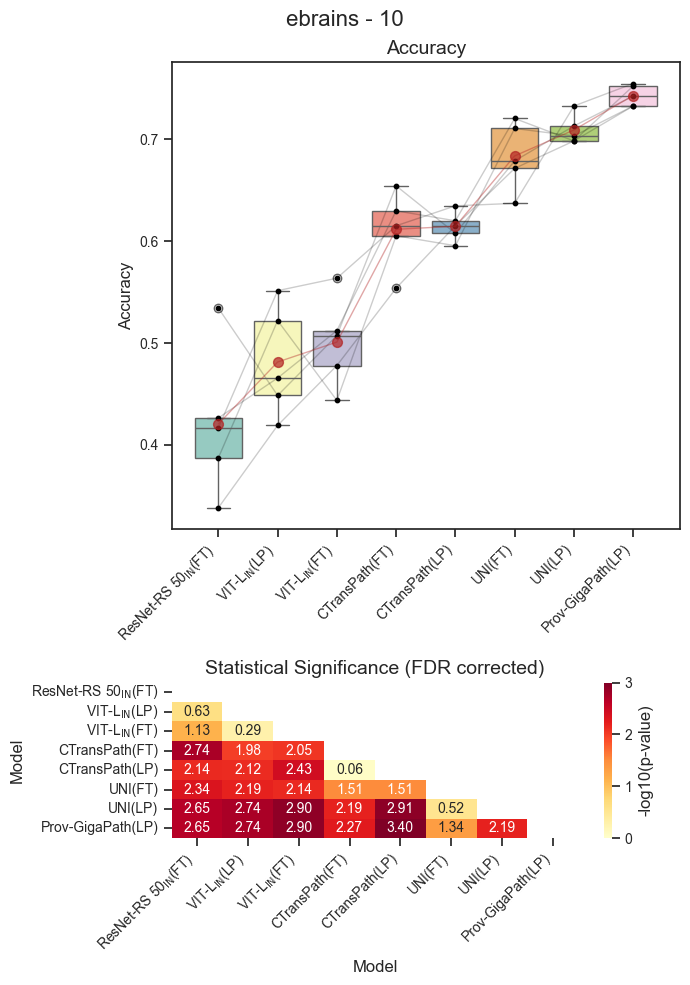

In [14]:
paired_box('ebrains', 10, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_acc.png", format="png", dpi=300)
plt.show()

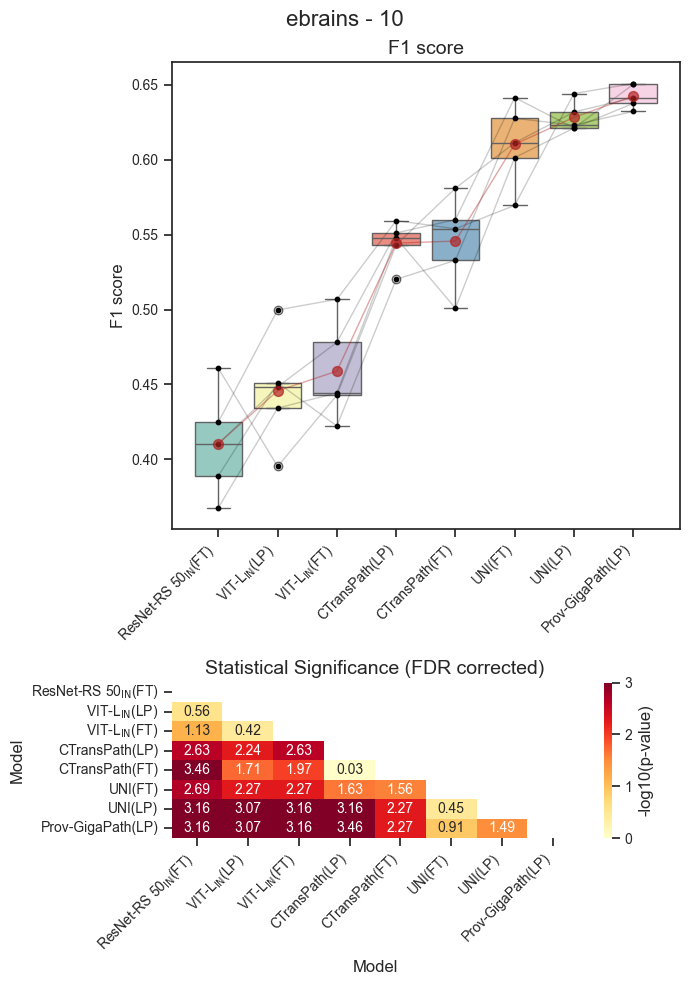

In [15]:
paired_box('ebrains', 10, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=300)
plt.show()

#### fig4

This fig shows the impact of patch number per case on model performace

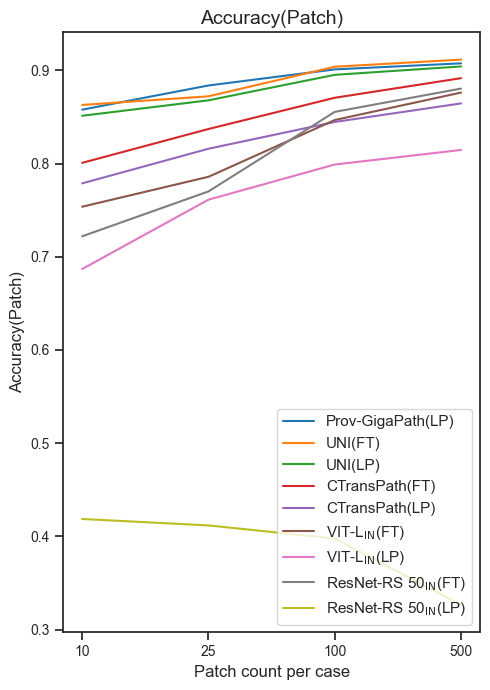

In [27]:

def draw_lines(target:Literal['cv', 'ebrains'], key:str, labels=None, fill=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        if labels is None:
            if limit == limits[0]:
                # sort on 10 limit
                df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
                df[f'average_{key}'] = df['label'].map(df_mean)
                df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
                labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(5, 7))
    x = np.arange(1, 1+len(limits))
    
    for i in range(len(labels)):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        c = colors[i]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=labels[i])
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key)
    plt.legend(loc='lower right')
    plt.title(key)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    return labels

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    'VIT-L$\\mathrm{_{IN}}$(FT)',
    'VIT-L$\\mathrm{_{IN}}$(LP)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(FT)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(LP)',
]
draw_lines('cv', 'Accuracy(Patch)', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_pacc.png", format="png", dpi=300)
plt.show()

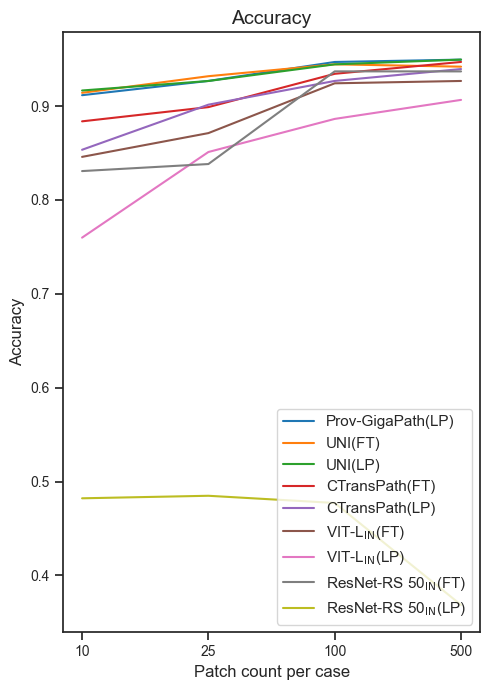

In [28]:
draw_lines('cv', 'Accuracy', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_acc.png", format="png", dpi=300)
plt.show()

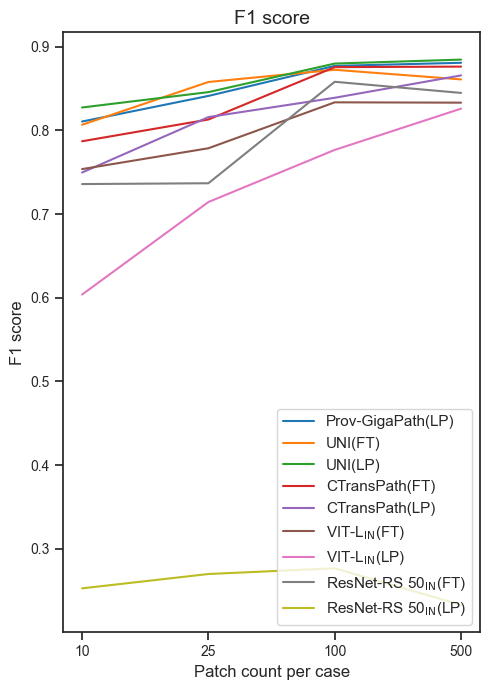

In [29]:
draw_lines('cv', 'F1 score', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_f1.png", format="png", dpi=300)
plt.show()

### Fig4: EBRAINS - lines

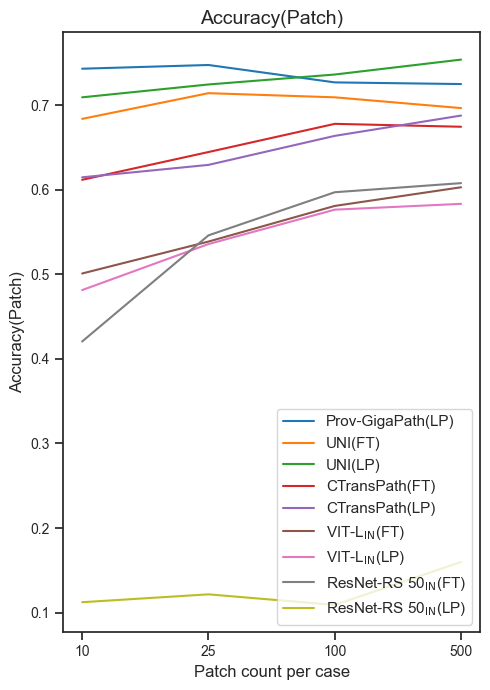

In [30]:
draw_lines('ebrains', 'Accuracy(Patch)', labels)
plt.savefig(f"out/figs/fig4_ebrains_pacc.png", format="png", dpi=300)
plt.show()

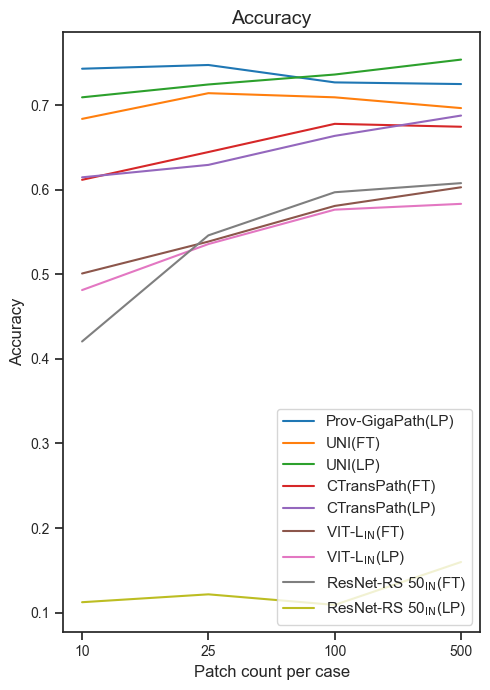

In [31]:
draw_lines('ebrains', 'Accuracy', labels)
plt.savefig(f"out/figs/fig4_ebrains_pacc.png", format="png", dpi=300)
plt.show()

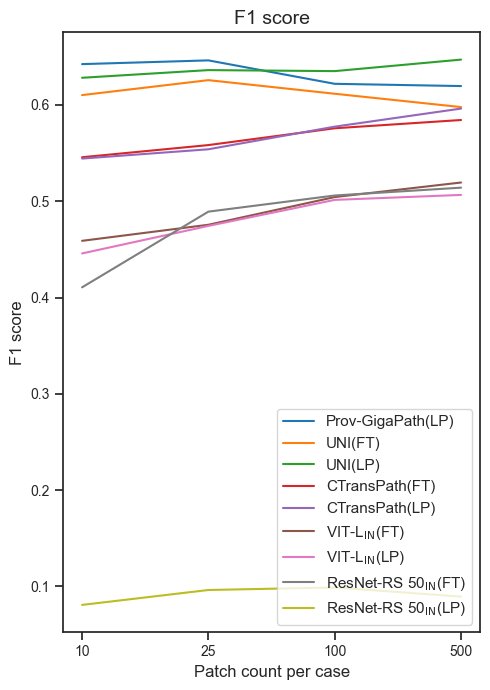

In [32]:
draw_lines('ebrains', 'F1 score', labels)
plt.savefig(f"out/figs/fig4_ebrains_f1.png", format="png", dpi=300)
plt.show()